## Capstone Phase 2

This notebook is a continuation of my capstone project of building my own Facial Emotion Recognition model. 

To recap: In phase 1, we have built a baseline model using pictures of my own face to train a model. However, the model is currently only trained on four different facial emotions (Angry, Happy, Neutral and Sad). 

In this phase: We will be aiming to make use of transfer learning and the FER2013 dataset from Kaggle to train a model that can classify more than four facial emotions and with a higher accuracy than our baseline model. 

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications.resnet50 import ResNet50

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

## Image Pre-processing

In [2]:
# the number of training examples utilized in one iteration
batch_size = 32

# set image size 224x224 for MobileNetV2
img_height = 224
img_width = 224

# path of train dataset
train_data_dir = "/kaggle/input/fer2013/train"

In [3]:
# converting pictures to numbers for modeling using keras.utils
# creating train data
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


2022-12-23 15:44:40.413217: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# converting pictures to numbers for modeling using keras.utils
# creating validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [5]:
# classes in dataset 
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


From this we can see that the dataset contains pictures of seven facial emotions.

## Visualize the data

2022-12-23 15:46:01.395243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


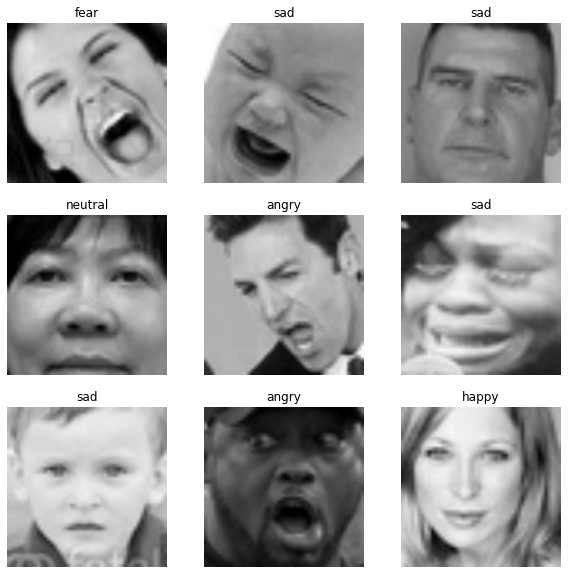

In [6]:
# plots first nine images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model Pre-processing

### Configure the dataset for performance
`Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

Standardize values to be in the `[0, 1]` range

In [8]:
normalization_layer = layers.Rescaling(1./255)

# apply scaling using .map
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

### Data Augmentation

Data augmentation is a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

In [9]:
# set up data augmentation function
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [10]:
# apply data augmentation to datasets
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)


2022-12-23 15:52:35.722233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 268 of 1000
2022-12-23 15:52:45.717453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 558 of 1000
2022-12-23 15:52:51.164779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


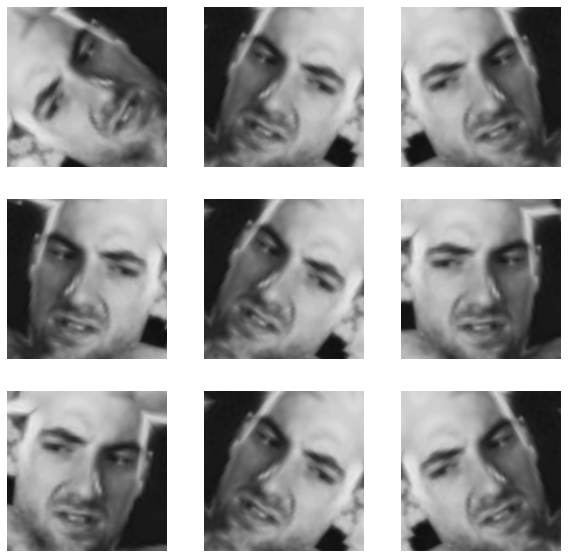

In [11]:
# visualise results of augmentation
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

## Transfer Learning

Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

### Loading Pre-trained Model

In [13]:
# loading MobileNetV2 model
model = tf.keras.applications.MobileNetV2()

# freeze the convolutional base
model.trainable = False

Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

### Building Model with Feature Extraction

In [14]:
# change base input
base_input = model.layers[0].input
# cut down output
base_output = model.layers[-2].output

final_output = layers.Dense(128)(base_output) 
final_output = layers.Activation("relu")(final_output) 
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation("relu")(final_output)
final_output = layers.Dense(7, activation="softmax")(final_output) # 7 classes in dataset
new_model = keras.Model(inputs = base_input, outputs = final_output)

# compile the model
new_model.compile(loss= "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [16]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

### Fit the Model

In [15]:
# train the model for 5 epochs
history = new_model.fit(train_ds, epochs = 5, validation_data=val_ds)

Epoch 1/5
718/718 [==============================] - 423s 585ms/step - loss: 1.5822 - accuracy: 0.3784 - val_loss: 1.5151 - val_accuracy: 0.4130
Epoch 2/5
718/718 [==============================] - 414s 577ms/step - loss: 1.4943 - accuracy: 0.4258 - val_loss: 1.5063 - val_accuracy: 0.4092
Epoch 3/5
718/718 [==============================] - 415s 578ms/step - loss: 1.4672 - accuracy: 0.4306 - val_loss: 1.4354 - val_accuracy: 0.4428
Epoch 4/5
718/718 [==============================] - 412s 574ms/step - loss: 1.4404 - accuracy: 0.4475 - val_loss: 1.4668 - val_accuracy: 0.4290
Epoch 5/5
718/718 [==============================] - 412s 573ms/step - loss: 1.4226 - accuracy: 0.4508 - val_loss: 1.4219 - val_accuracy: 0.4532


### Training Results

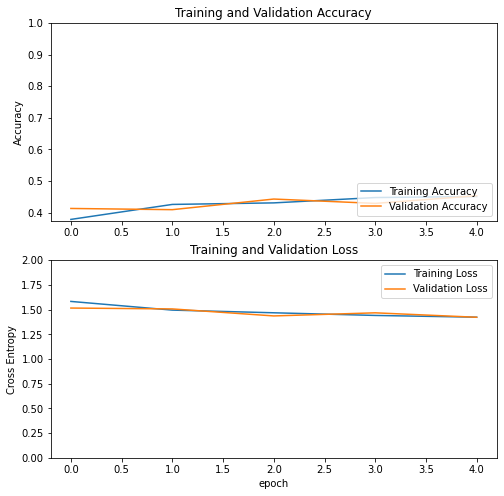

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

### Unfreeze top layers of the model

In [19]:
# unfreeze top layers of the model
model.trainable = True

In [20]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  156


### Compile the model

In [21]:
# compile the model using a lower learning rate to prevent overfitting
new_model.compile(loss= "sparse_categorical_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3/10),
                  metrics = ["accuracy"])

In [22]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [23]:
len(new_model.trainable_variables)

60

### Continue training the model

In [24]:
total_epochs =  10

history_fine = new_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/10
718/718 [==============================] - 635s 878ms/step - loss: 1.3448 - accuracy: 0.4820 - val_loss: 1.3846 - val_accuracy: 0.4966
Epoch 6/10
718/718 [==============================] - 629s 876ms/step - loss: 1.1708 - accuracy: 0.5524 - val_loss: 1.2277 - val_accuracy: 0.5415
Epoch 7/10
718/718 [==============================] - 627s 873ms/step - loss: 1.0866 - accuracy: 0.5871 - val_loss: 1.1783 - val_accuracy: 0.5659
Epoch 8/10
718/718 [==============================] - 625s 870ms/step - loss: 1.0223 - accuracy: 0.6122 - val_loss: 1.1738 - val_accuracy: 0.5645
Epoch 9/10
718/718 [==============================] - 626s 872ms/step - loss: 0.9789 - accuracy: 0.6264 - val_loss: 1.1328 - val_accuracy: 0.5813
Epoch 10/10
718/718 [==============================] - 637s 888ms/step - loss: 0.9321 - accuracy: 0.6461 - val_loss: 1.0958 - val_accuracy: 0.5933


We observe that there is greater accuracy after unfreezing the network. The reason for the observation lies in the fact that the frozen ResNet50 model was trained from a distribution of images that were fundamentally different from this particular dataset. This mismatch in data distribution causes the poor performance as the transformations performed by the frozen network are not tuned to the FER2013 images. Unfreezing the network lets the neurons actually learn the FER2013 images which is responsible for the better result.

### Training Results

In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

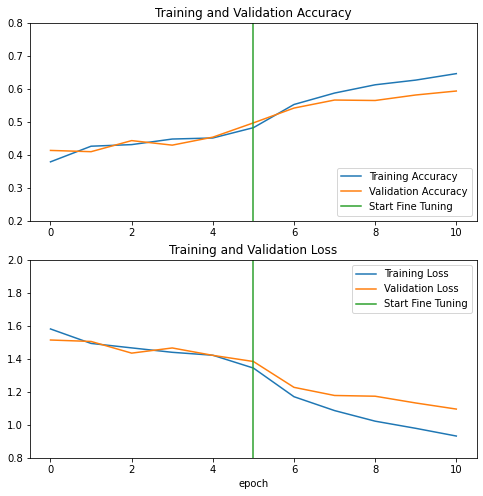

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 0.8])
plt.plot([5,5],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.8, 2])
plt.plot([5,5],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Based on the training evaluation, we can see that after fine tuning, we started to get better results. 

## Model Evaluation and Prediction

### Prepare test dataset

In [54]:
# converting pictures to numbers for modeling using keras.utils
# creating train data
test_data_dir = "/kaggle/input/fer2013/test"

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7178 files belonging to 7 classes.


In [55]:
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

### Evaluate Model with Test Dataset

In [71]:
loss, accuracy = new_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

225/225 [==============================] - 77s 339ms/step - loss: 1.0431 - accuracy: 0.6180
Test accuracy : 0.6179994344711304


### Visualise Predictions

Predictions:
 [4 2 3 4 0 0 2 6 3 4 5 5 6 3 5 4 4 5 2 2 0 3 6 1 2 5 3 3 5 3 4 5]
Labels:
 [5 2 3 5 0 5 5 2 3 4 4 5 6 3 0 5 4 5 4 2 2 3 6 1 2 6 3 3 0 3 0 2]


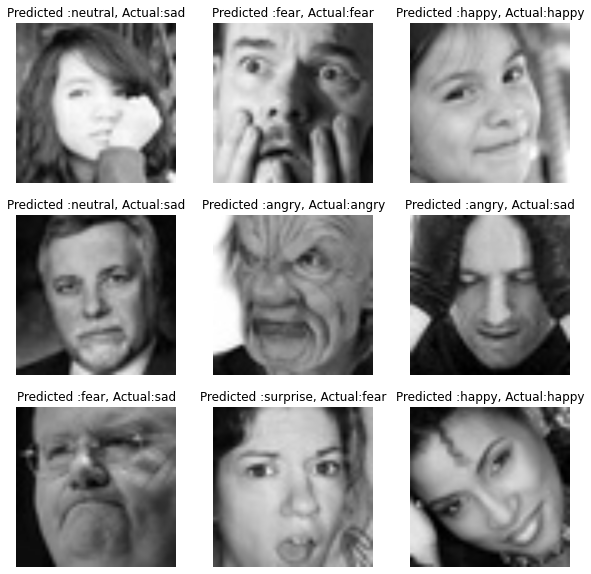

In [91]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = new_model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions =np.argmax(predictions, axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(f"Predicted :{class_names[predictions[i]]}, Actual:{class_names[label_batch[i]]}")
  plt.axis("off")

Looking at the predictions and the actual emotion, I feel that some of these photos are actually difficult to understand even as a human. 

### Classification Report

In [95]:
print("Classification Report: \n", classification_report(predictions, label_batch,target_names=['Angry',
                                                                                                'Disgust',
                                                                                               'Fear',
                                                                                               'Happy',
                                                                                               'Neutral',
                                                                                               'Sad',
                                                                                               'Surprise']))
# Better scores recorded on CNN as seen below as opposed to ANN as seen above

Classification Report: 
               precision    recall  f1-score   support

       Angry       0.25      0.33      0.29         3
     Disgust       1.00      1.00      1.00         1
        Fear       0.50      0.60      0.55         5
       Happy       1.00      1.00      1.00         7
     Neutral       0.50      0.33      0.40         6
         Sad       0.29      0.29      0.29         7
    Surprise       0.67      0.67      0.67         3

    accuracy                           0.56        32
   macro avg       0.60      0.60      0.60        32
weighted avg       0.57      0.56      0.56        32



Based on the classification report, we can see that Angry and Sad has the lowest Precision followed by Neutral and Fear. 

### Save Model

In [96]:
new_model.save('transfer_learning')

2022-12-23 18:45:03.048396: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
